In [1]:
# Standard library imports
import os
import re
import random
import shutil
from datetime import datetime
from collections import OrderedDict

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch and TorchVision libraries for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.models as models
from torchvision import transforms, datasets
from PIL import Image

# Scikit-Learn for evaluation metrics and data splitting|
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imbalanced-learn for oversampling to address class imbalance
from imblearn.over_sampling import RandomOverSampler

from torchvision import transforms
from torchvision.transforms import functional as F
from PIL import Image
from PIL import Image
from PIL import UnidentifiedImageError
from tqdm import tqdm

import os, re, random
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from google.colab import drive

In [3]:
# ─── 1) MOUNT GOOGLE DRIVE ──────────────────────────────────────────────
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# ─── LOAD LABELS & BUILD CLASS MAP ───────────────────────────────────────
labels = pd.read_csv(
    "/content/drive/MyDrive/case_grade_match.csv"
).drop(index=64, errors='ignore').reset_index(drop=True)

In [5]:
# Note that case 65 is not included in the analysis as it was not labelled
labels.loc[62:65,:]

Case  Class
62    63      3
63    64      3
64    66      3
65    67      4

In [6]:
filtered_patches_dir = '/content/drive/MyDrive/CMIL_SP2025_Patches_Apr27'
os.path.exists(filtered_patches_dir)

True

In [9]:
all_files = os.listdir(filtered_patches_dir)
len(all_files)

83717

In [10]:
# === Slice-Level Grouping ===

# Edit 10/19: identified scenario where patches are not being matched:
#     1) missing space between 'match' / 'unmatched' and number, eg. case_38_match14_h&e_patch25.png
#     2) Additionally, some names include 'labels' (not relevant to this regex which is only looking at case matching but thought I would flag),
#         eg. case_82_unmatched3_h&e-labels_patch32.png
def group_patches_by_slice(root_dir):
    case_slices = defaultdict(list)
    # list of unconventionally-named patches
    invalid_file_names = []
    flexibility_needed_counter = 0
    for root, _, files in os.walk(root_dir):
        for filename in files:
            if filename.endswith(".png"):
              #  match = re.match(r"case_(\d+)_([\w&\-]+_\d+)_", filename)
                match = re.match(r"case_(\d+)_([a-z]+_\d+)_", filename) #check if some patches are named differently
                if match:
                    case_id = int(match.group(1))
                    slice_id = match.group(2)
                    key = (case_id, slice_id)
                    case_slices[key].append(os.path.join(root, filename))

                    continue
                # if a file doesn't match, try regex without "_" between "match" / "unmatched" and number
                match = re.match(r"case_(\d+)_([a-z]+\d+)_", filename)
                if match:
                    case_id = int(match.group(1))
                    slice_id = match.group(2)
                    # adding underscore between "match" / "unmatched" and number
                    slice_id = re.sub(r'([A-Za-z])(\d)', r'\1_\2', slice_id)
                    key = (case_id, slice_id)
                    case_slices[key].append(os.path.join(root, filename))
                    flexibility_needed_counter += 1

                    continue
                invalid_file_names.append(os.path.join(root, filename))

    # Print summary of invalid files
    if invalid_file_names:
        print(f"Found {len(invalid_file_names)} files not following naming convention:")
        for f in invalid_file_names:
            print("  ", f)
    else:
        print(f"All {flexibility_needed_counter} invalid file names were handled.")
    return case_slices

In [11]:
# === Load Patches by Slice ===
patches = group_patches_by_slice(filtered_patches_dir)

All 3808 invalid file names were handled.


In [12]:
len(patches)

378

In [13]:
tot_patches = 0
for ke in patches.keys():
  tot_patches = tot_patches + len(patches[ke])
tot_patches

83717

Some patches are getting lost (need to make the 'match = re.match(....)' code more general)

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [15]:
# Training transform (augmented)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [16]:
# === Build Label Map by Slice ===
slice_to_class = {}
valid_classes = [1.0, 3.0, 4.0]
for (case_id, slice_id), paths in patches.items():
    raw_label = labels.loc[labels['Case'] == case_id, 'Class']
    if not raw_label.empty and raw_label.item() in valid_classes:
        label = 0 if raw_label.item() == 1.0 else 1
        slice_to_class[(case_id, slice_id)] = label

In [17]:
len(slice_to_class) # Low-grade slices are removed

366

In [18]:
slice_to_class[(106, 'match_1')]

1

In [19]:
# === Stratified Split by Slice ===
slices_by_class = defaultdict(list)
for key, label in slice_to_class.items():
    slices_by_class[label].append(key) # Dictonary of length 2

In [20]:
slices_by_class.keys()

dict_keys([1, 0])

In [21]:
# number of cases
unique_case = {t[0] for v in slices_by_class.values() for t in v}
len(unique_case)

86

In [22]:
# split by cases
def split_by_case_stratified(slices_by_class, random_state=42):
    # 1) Build case -> label map and validate no mixed-label cases
    case_to_labels = defaultdict(set)
    for label, items in slices_by_class.items():
        for case_id, _ in items:
            case_to_labels[case_id].add(label)
    mixed = {cid: labs for cid, labs in case_to_labels.items() if len(labs) > 1}
    if mixed:
        raise ValueError(f"Found cases with mixed labels (would cause leakage): {mixed}")

    # Flatten to case list and aligned labels
    case_ids = []
    case_labels = []
    for cid, labs in case_to_labels.items():
        case_ids.append(cid)
        case_labels.append(next(iter(labs)))  # the single label for this case

    # 2) Split *cases* with stratification by case-level label
    # 60% train, 40% temp
    case_train, case_temp, y_train, y_temp = train_test_split(
        case_ids, case_labels, test_size=0.4, stratify=case_labels, random_state=random_state
    )
    # temp -> 50/50 to make 20%/20% val/test
    case_val, case_test, _, _ = train_test_split(
        case_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=random_state
    )

    case_train = set(case_train)
    case_val   = set(case_val)
    case_test  = set(case_test)

    # 3) Map case splits back to slice-level lists (no leakage)
    train_slices, val_slices, test_slices = [], [], []
    for label, items in slices_by_class.items():
        for case_id, slice_key in items:
            if case_id in case_train:
                train_slices.append((case_id, slice_key))
            elif case_id in case_val:
                val_slices.append((case_id, slice_key))
            elif case_id in case_test:
                test_slices.append((case_id, slice_key))
            # else: shouldn't happen

    return train_slices, val_slices, test_slices

train_slices, val_slices, test_slices = split_by_case_stratified(slices_by_class)


In [23]:
# check train, test and validation set doesnt have overlapping cases
set([slice[0] for slice in train_slices]) & set([slice[0] for slice in test_slices]) & set([slice[0] for slice in val_slices])

set()

In [24]:
# number of cases after spliting
len(set([slice[0] for slice in train_slices]) | set([slice[0] for slice in test_slices]) | set([slice[0] for slice in val_slices]))

86

In [25]:
train_patches = {k: patches[k] for k in train_slices}
val_patches   = {k: patches[k] for k in val_slices}
test_patches  = {k: patches[k] for k in test_slices}

In [26]:
# === Filter to H&E Only ===

def filter_by_stain(d, keyword):
    out, dropped = {}, []
    for k, paths in d.items():
        filtered = [p for p in paths if keyword.lower() in os.path.basename(p).lower()]
        if filtered:
            out[k] = filtered
        else:
            dropped.append(k)
    if dropped:
        print(f"⚠️ Dropped slices with no '{keyword}' patches: {dropped}")
    return out


train_patches = filter_by_stain(train_patches, "h&e")
val_patches   = filter_by_stain(val_patches, "h&e")
test_patches  = filter_by_stain(test_patches, "h&e")

⚠️ Dropped slices with no 'h&e' patches: [(18, 'unmatched_4'), (87, 'unmatched_2'), (24, 'unmatched_9'), (24, 'unmatched_10'), (22, 'unmatched_12'), (22, 'unmatched_13'), (27, 'unmatched_9'), (27, 'unmatched_8'), (27, 'unmatched_1'), (27, 'match_2'), (23, 'match_1')]
⚠️ Dropped slices with no 'h&e' patches: [(72, 'unmatched_5'), (73, 'unmatched_3'), (15, 'unmatched_11'), (15, 'unmatched_10'), (15, 'unmatched_12'), (15, 'unmatched_13'), (15, 'match_1'), (15, 'match_2'), (72, 'unmatched_6'), (73, 'unmatched_4'), (50, 'match_5'), (50, 'match_4'), (21, 'unmatched_4'), (21, 'match_1')]
⚠️ Dropped slices with no 'h&e' patches: [(104, 'match_15'), (38, 'match_27'), (38, 'match_28'), (38, 'match_29'), (38, 'match_22')]


In [27]:
len(train_patches)

197

In [28]:
# === MILDataset with slice-level keys ===
class SliceMILDataset(Dataset):
    def __init__(self, patch_dict, label_map, transform=None, emergency_cap=800):
      #emergency_cap: upper limit on how many patches per bag to include, why have a limit? how set the limit?
      #If a bag has too many patches (say 3000), only randomly keeps up to emergency_cap (default 800)
      #Prevents out-of-memory errors during training. - needed or not?
      #transform: optional torchvision transform (e.g., resizing, normalization) - same as manual?
        self.transform = transform
        self.emergency_cap = emergency_cap
        # self.bags: list of lists of image paths (each “bag” = slice).
        # self.labels: list of corresponding labels for each bag.
        self.bags, self.labels = [], []
        for slice_key, paths in patch_dict.items():
            self.bags.append(paths)
            self.labels.append(label_map[slice_key])

    # Required for PyTorch datasets — tells how many samples (bags) exist.
    # Enables len(dataset) to work and is used by DataLoader for batching.
    def __len__(self): return len(self.bags)


    # The method below is called whenever PyTorch asks for a sample.
    # Retrieves the list of patch file paths for that bag.
    def __getitem__(self, idx):
        paths = self.bags[idx] # idx is the index of the bag you want.
        imgs = []
        for p in paths:   # Loops through each patch path in the bag.
            try:
                img = Image.open(p).convert('RGB')#Change the color transformation - YCbCr, HSV
                if self.transform: # Applies transforms if provided (resize, normalize, etc.)
                    img = self.transform(img)
                imgs.append(img)
            except:
                continue #why try-except, what error? Why corrupt patches?
        if len(imgs) == 0:
            raise ValueError(f"No usable patches in slice {paths}")
        if self.emergency_cap and len(imgs) > self.emergency_cap:
            imgs = random.sample(imgs, self.emergency_cap)
        return torch.stack(imgs), torch.tensor(self.labels[idx], dtype=torch.long)
        #Stacks all transformed image tensors into a single tensor of shape:
        #(num_patches, C, H, W)
        #(e.g., (500, 3, 224, 224) for 500 patches).
        #Converts the label to a PyTorch tensor of type long (needed for classification loss).
        #Returns (bag_tensor, label_tensor) as one sample.



In [29]:
# this pools the patch level features into single bag level representation for MIL
class AttentionPool(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
      #input_dim: the dimensionality of each input feature vector (e.g., 512 if you’re using a CNN encoder like ResNet).
      #hidden_dim: the size of the hidden layer used inside the attention mechanism (default = 128).
      #This defines how much capacity the attention sub-network has to learn complex relationships.
        super().__init__()
        # creates small neural network to compute attention scores for each patch
        # each patch embedding is passed through a linear layer, tanh for nonlinearity, and another linear layer to get a scalar score
        self.attention = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x, return_weights=False):
        # x is of shape (B, M, D) where B is batch size or number of cases,
        # M is number of patches per bag, and D is the embedding dimensions for each patch
        weights = self.attention(x)     # (B, M, 1)
        weights = torch.softmax(weights, dim=1) # softmax so that weights are positive
        # outputs attention scores for each patch and normalized with softmax
        # D is the embedding dimension which is size of feature vector for each patch after going through the patch classifier
        weighted_x = (weights * x).sum(dim=1)  # (B, D)
        # returning the raw attention weights per patch just to help with visualization of the weights for each patch
        if return_weights:
            return weighted_x, weights.squeeze(-1)  # (B, D), (B, M)
        return weighted_x

# using Densenet to extract features at the patch-level, and adaptaive pooling for patch-level feature pooling
# the patch features are passed into Attentionpool which learns the weights across patches and combines them into a single bag label

In [30]:
class AttnMIL(nn.Module):
    def __init__(self, base_model, num_classes=2, embed_dim=512):
        super().__init__()
        # grabbing the convolutional feature extractor from the pretrained model
        self.features = base_model.features
        # applying adaptive average pooling to compress to feature map of 2x2 grid
        # you get 4 spatial vectors per patch
        self.pool = nn.AdaptiveAvgPool2d((2,2))  # richer than (1,1) - tunable!
        # meaning that you'll get 4 vectors per patch which will then be flattened
        self.patch_projector = nn.Linear(base_model.classifier.in_features * 4, embed_dim)

        # Attention module (your earlier class) that produces per-patch weights and returns a bag embedding (weighted sum) of size embed_dim.
        self.attention_pool = AttentionPool(embed_dim)

        # Final classifier that maps the bag embedding to logits over classes.
        self.classifier = nn.Linear(embed_dim, num_classes)


    def forward(self, x, return_patch_logits=False, return_attn_weights=False):
        if x.dim() == 4: # why the need to check?
            x = x.unsqueeze(0)
        # typically after CNN you get 3D tensor with num channels, height and width of image
        # but we packed the patches into a bag by case (the tensor), so B is batch size, M is number of patches per bag
        B, M, C, H, W = x.shape
        x = x.view(B*M, C, H, W) # put all patches in the batch together

        features = self.features(x) # exxtracting cnn features for each patch, output shape: (B*M, C', H', W')
        pooled = self.pool(features).view(B*M, -1) # pool each feature map to a 2x2 grid and flatten, output shape: (B*M, 4*C')
        embedded = self.patch_projector(pooled).view(B, M, -1) # project each patch into shared embedding space, output shape (B, M, embed_dim)
        # just ensuring all the patches are transformed into vectors of the same length for attention

        # in order to get patch level predictions
        # Optional per-patch logits: apply the bag classifier to each patch embedding independently. Shape (B, M, num_classes). Useful for diagnostics/auxiliary losses.
        if return_patch_logits:
            logits = self.classifier(embedded)  # (B, M, 2)
            return logits
        # returning attention weights for visualization
        if return_attn_weights:
            bag_emb, attn_weights = self.attention_pool(embedded, return_weights=True)
            logits = self.classifier(bag_emb)
            return logits, attn_weights  # bag prediction + per-patch attention scores, why logits here when returning at the end

        # applying attention
        #computing a weighted average of patch embeddings using attention, and then is passed through the classifier to get bag level prediction
        bag_emb = self.attention_pool(embedded) #Shape: (B, embed_dim) + weights (B, M)
        logits = self.classifier(bag_emb) # Shape: (B, 2)
        return logits

# What is the effect of M varying in each bag?

In [31]:
# Set up datasets
# Set up slice-based MIL datasets
# dict mapping slice_key -> list_of_patch_paths for the train split.
# dict mapping slice_key -> class_label.
# image augmentations for training (e.g., flips/crops/normalization).
train_ds = SliceMILDataset(train_patches, slice_to_class, transform=train_transform)

# Uses (usually) lighter or no augmentation (transform) to mimic evaluation conditions.
val_ds   = SliceMILDataset(val_patches, slice_to_class, transform=transform)

# emergency_cap=None disables the cap on patches per bag (use all patches). Helpful to evaluate full performance without subsampling.
test_ds  = SliceMILDataset(test_patches, slice_to_class, transform=transform, emergency_cap=None)

# help generalize better and reduce overfitting
# Wraps train_ds in a PyTorch DataLoader.
# batch_size=1: in MIL, each bag (slice) can contain a variable number of patches; batching multiple bags together often requires padding/collate tricks. Why? Is it because bag sizes are different? Using 1 bag per batch keeps it simple and memory-safe.
# shuffle=True: randomizes bag order each epoch → improves generalization and reduces overfitting.
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
# don't want to shuffle so taht you get consistent, repeatable evaluation
val_loader   = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)

# If bags vary wildly in size and you want larger batches, you can implement a custom collate_fn to pad/truncate bags, but that adds complexity.

In [38]:
# Provide summarize info of number of cases, patches, class distribution and number of slices
def summarize_split(patch_dict, label_map=None, split_name=""):
    # Count cases
    num_cases = len(set(k[0] for k in patch_dict if isinstance(k, tuple) and len(k) > 0))

    # Count total patches
    total_patches = sum(len(paths) for paths in patch_dict.values())

    # Count per class (if label map provided)
    class_counts = Counter()
    if label_map:
        class_counts.update([label_map[c] for c in patch_dict.keys() if c in label_map])

    # Output
    print(f"\n🔹 {split_name} Split")
    print(f"Cases: {num_cases}")
    print(f"Slices: {len(patch_dict)}")
    print(f"Patches: {total_patches}")
    if class_counts:
        print(f"Class distribution: {dict(class_counts)}")

# Run for all splits
summarize_split(train_patches, slice_to_class, split_name="Train")
summarize_split(val_patches, slice_to_class, split_name="Validation")
summarize_split(test_patches, slice_to_class, split_name="Test")


🔹 Train Split
Cases: 51
Slices: 197
Patches: 23912
Class distribution: {1: 109, 0: 88}

🔹 Validation Split
Cases: 17
Slices: 60
Patches: 7832
Class distribution: {1: 44, 0: 16}

🔹 Test Split
Cases: 18
Slices: 79
Patches: 7993
Class distribution: {1: 66, 0: 13}


hannah's code below

In [39]:
def summarize_patch_distribution(patch_dict, split_name):
    patch_counts = {case: len(patches) for case, patches in patch_dict.items()}
    print(f"\n📦 Patch counts for {split_name}:")
    for case, count in sorted(patch_counts.items()):
        print(f"  Case {case}: {count} patches")

    df = pd.DataFrame(list(patch_counts.items()), columns=["Case", "Patch Count"])
    df.to_csv(f"{split_name.lower()}_patch_counts.csv", index=False)
    return df

# Call for each split
train_df = summarize_patch_distribution(train_patches, "Train")
val_df   = summarize_patch_distribution(val_patches, "Validation")
test_df  = summarize_patch_distribution(test_patches, "Test")


📦 Patch counts for Train:
  Case (1, 'match_1'): 64 patches
  Case (1, 'unmatched_1'): 68 patches
  Case (1, 'unmatched_2'): 74 patches
  Case (1, 'unmatched_3'): 74 patches
  Case (3, 'match_1'): 122 patches
  Case (3, 'unmatched_1'): 70 patches
  Case (3, 'unmatched_2'): 108 patches
  Case (3, 'unmatched_3'): 192 patches
  Case (4, 'match_1'): 124 patches
  Case (4, 'unmatched_1'): 163 patches
  Case (4, 'unmatched_2'): 233 patches
  Case (5, 'match_1'): 142 patches
  Case (5, 'unmatched_1'): 132 patches
  Case (9, 'match_1'): 53 patches
  Case (9, 'unmatched_1'): 50 patches
  Case (9, 'unmatched_2'): 60 patches
  Case (11, 'match_1'): 80 patches
  Case (11, 'unmatched_1'): 95 patches
  Case (11, 'unmatched_2'): 104 patches
  Case (11, 'unmatched_3'): 46 patches
  Case (14, 'match_1'): 120 patches
  Case (14, 'match_3'): 58 patches
  Case (14, 'match_4'): 88 patches
  Case (14, 'unmatched_1'): 102 patches
  Case (14, 'unmatched_2'): 72 patches
  Case (14, 'unmatched_3'): 40 patches


In [40]:
from collections import defaultdict

def count_patches_by_class(patch_dict, case_to_class, split_name):
    class_patch_counts = defaultdict(int)

    for case, patches in patch_dict.items():
        label = case_to_class[case]
        class_patch_counts[label] += len(patches)

    print(f"\n🧬 Patch count by class for {split_name}:")
    print(f"  Benign (0):     {class_patch_counts[0]} patches")
    print(f"  High-grade (1): {class_patch_counts[1]} patches")

    return class_patch_counts

# Count patches per class for each split
train_counts = count_patches_by_class(train_patches, slice_to_class, "Train")
val_counts   = count_patches_by_class(val_patches, slice_to_class, "Validation")
test_counts  = count_patches_by_class(test_patches, slice_to_class, "Test")


🧬 Patch count by class for Train:
  Benign (0):     10684 patches
  High-grade (1): 13228 patches

🧬 Patch count by class for Validation:
  Benign (0):     1869 patches
  High-grade (1): 5963 patches

🧬 Patch count by class for Test:
  Benign (0):     1706 patches
  High-grade (1): 6287 patches


In [40]:
# add function to save checkpoint to drive (instead of local path done by Hannah)
def save_checkpoint_to_drive(model, arch, optimizer, epoch, drive_folder="MyDrive/Checkpoints"):
    checkpoint_dir = os.path.join("/content/drive", drive_folder)
    os.makedirs(checkpoint_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{checkpoint_dir}/{timestamp}_{arch}_epoch{epoch}.pth"

    checkpoint = {
        "arch": arch,
        "model_state_dict": model.state_dict(),
        "epoch": epoch,
        "optimizer_state_dict": optimizer.state_dict(),
    }

    torch.save(checkpoint, filename)
    print(f"✅ Checkpoint saved to Google Drive: {filename}")

def validation(model, criterion, val_loader):
    val_loss = 0
    correct_total = 0
    sample_total = 0
    model.eval()
    with torch.no_grad():
        for bags, labels in val_loader:
            bags = bags.to(device)
            labels = labels.to(device)
            outputs = model(bags)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            preds = torch.argmax(outputs, dim=1)
            correct_total += (preds == labels).sum().item()
            sample_total += labels.size(0)
    return val_loss / sample_total, correct_total / sample_total

# change train model function by adding the start_epoch variable
def train_model(model, optimizer, criterion, train_loader, val_loader, arch, epochs=5, start_epoch=0):
    for epoch in range(start_epoch, epochs):
        model.train()
        running_loss = 0
        for bags, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            bags = bags.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(bags)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        val_loss, val_acc = validation(model, criterion, val_loader)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {running_loss/len(train_loader):.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}")
        save_checkpoint_to_drive(model, arch, optimizer, epoch+1, drive_folder="MyDrive/Checkpoints")
    return model

In [41]:
# ------------------- Load pretrained patch model -------------------
# used for classifiing individual image patches, its convolutional layers are used as frozen feature extractor in MIL
class PatchClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
        # loading the pre trained densenet model
        self.features = base.features
        # compress final convolutional output of each image to 2x2 feature map
        self.pool = nn.AdaptiveAvgPool2d((2,2))
        self.classifier = nn.Linear(base.classifier.in_features * 4, 2)

    def forward(self, x):
        # first passes input images through Densenet convolutional layers to get feature maps
        x = self.features(x)
        # applies pooling
        x = self.pool(x).view(x.size(0), -1)
        # passes to final classifier layer to get the logits
        return self.classifier(x)

patch_model = PatchClassifier()
# patch_model.load_state_dict(torch.load(os.path.join(filtered_patches_dir, "patch_classifier.pth")))
patch_model.eval()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 75.8MB/s]


PatchClassifier(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# ------------------- Inject backbone into MIL -------------------
# creating new densenet model with no pretrained weights
base_model = models.densenet121(weights=None)
# replacing its features or convolutional layers with the pretrained ones from the patch classifier that we loaded
base_model.features = patch_model.features

# creating the Attention MIL model using the pretrained feature extractor
model = AttnMIL(base_model=base_model).to(device)
# freezing the feature extractor
for param in model.features.parameters():
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
arch = "densenet121_simplemil"


train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

In [48]:
# check if we need to load from checkpoint before training
checkpoint_dir = "/content/drive/MyDrive/Checkpoints"
checkpoint_pattern = re.compile(r'epoch(\d+)\.pth')
start_epoch = 0
checkpoint_path = None
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pth')]

def load_latest_checkpoint(checkpoint_dir, model, optimizer, device):
    # Find all files in the directory
    checkpoint_files = [f for f in os.listdir(checkpoint_dir) if checkpoint_pattern.search(f)]
    if len(checkpoint_files)>=1:
        # Sort by extracted epoch number
        checkpoint_files.sort(
            key=lambda x: int(checkpoint_pattern.search(x).group(1)) if checkpoint_pattern.search(x) else -1)
        # Get the path of the latest checkpoint (last one in the sorted list)
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_files[-1])
        print(f"Latest checkpoint in directory is **{checkpoint_path}**")

        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        return model, optimizer, start_epoch
    return model, optimizer, 0

model, optimizer, start_epoch = load_latest_checkpoint(checkpoint_dir, model, optimizer, device)

Latest checkpoint in directory is **/content/drive/MyDrive/Checkpoints/20251021_023201_densenet121_simplemil_epoch5.pth**


In [49]:
train_model(model, optimizer, criterion, train_loader, val_loader, arch, epochs=5, start_epoch=start_epoch)

AttnMIL(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1

In [60]:
# ------------ model evaluation ---------------------
model.eval()
all_preds, all_trues = [], []
all_patch_preds, all_patch_trues = [], []
all_attn_weights = []

with torch.no_grad():
    for X_bag, y in test_loader:
        X_bag, y = X_bag.to(device), y.to(device)

        # 1. Slice-level prediction (also getting attention weights)
        bag_logits,attn_weights = model(X_bag, return_attn_weights=True)
        bag_pred = bag_logits.argmax(dim=1)
        all_preds.extend(bag_pred.cpu().numpy())
        all_trues.extend(y.cpu().numpy())

        # 2. Patch-level prediction
        patch_logits = model(X_bag, return_patch_logits=True)
        patch_pred = patch_logits.argmax(dim=2).squeeze(0).cpu().numpy()
        patch_labels = y.cpu().item() * np.ones_like(patch_pred)
        all_patch_preds.extend(patch_pred)
        all_patch_trues.extend(patch_labels)

        # 3. Save Attention Weights (for visualization)
        attn_weights = attn_weights.squeeze(0).cpu().numpy()
        all_attn_weights.append(attn_weights)

# 4. Case Level Majority Vote Aggregation
slice_keys = list(test_patches.keys())
case_preds = defaultdict(list)
case_trues = {}

for i in range(len(all_preds)):

    pred = all_preds[i]
    true_label = all_trues[i]
    case_id = slice_keys[i][0]
    case_preds[case_id].append(pred)

    # Map the true label to the case_id
    case_trues[case_id] = true_label

# Majority vote per case (same logic as before)
final_preds = []
final_trues = []
for case_id in sorted(case_preds.keys()):
    votes = case_preds[case_id]
    # Use max with key=votes.count for majority vote
    maj_pred = max(set(votes), key=votes.count)
    final_preds.append(maj_pred)
    final_trues.append(case_trues[case_id])

# Report
print("=== Aggregated Case-Level Classification Report ===")
print(classification_report(final_trues, final_preds, target_names=['Benign', 'High-grade CMIL']))

print("=== Slice-Level Classification Report ===")
print(classification_report(all_trues, all_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

print("\n=== Patch-Level Classification Report (weak labels) ===")
print(classification_report(all_patch_trues, all_patch_preds, target_names=['Benign', 'High-grade CMIL'], labels=[0,1]))

=== Aggregated Case-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.67      0.67      0.67         6
High-grade CMIL       0.83      0.83      0.83        12

       accuracy                           0.78        18
      macro avg       0.75      0.75      0.75        18
   weighted avg       0.78      0.78      0.78        18

=== Slice-Level Classification Report ===
                 precision    recall  f1-score   support

         Benign       0.60      0.69      0.64        13
High-grade CMIL       0.94      0.91      0.92        66

       accuracy                           0.87        79
      macro avg       0.77      0.80      0.78        79
   weighted avg       0.88      0.87      0.88        79


=== Patch-Level Classification Report (weak labels) ===
                 precision    recall  f1-score   support

         Benign       0.31      0.42      0.35      1706
High-grade CMIL       0.82      0.75      0.

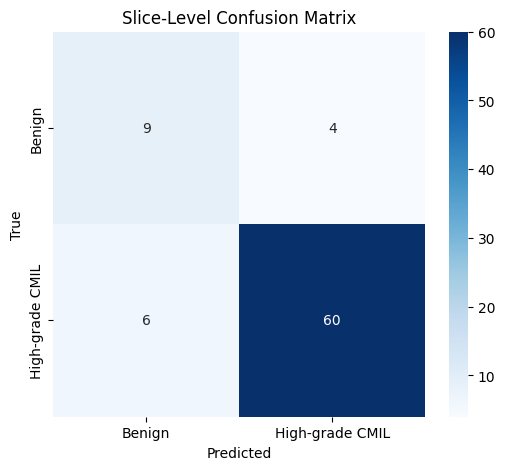

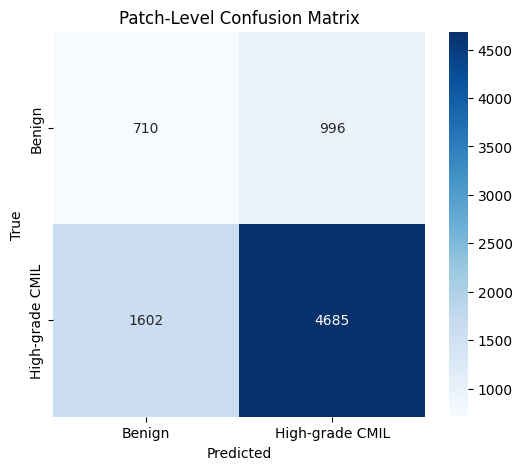

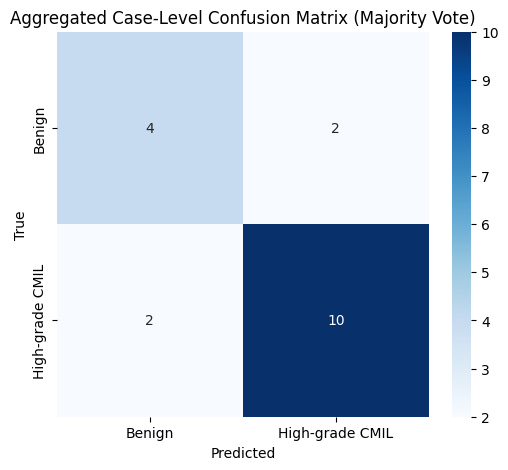

In [61]:
def plot_confusion_matrix(trues, preds, title):
    cm = confusion_matrix(trues, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'High-grade CMIL'],
                yticklabels=['Benign', 'High-grade CMIL'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

# --- Plotting the matrices ---

# 1. Slice-Level and Patch-Level
for name, preds, trues in [
    ("Slice-Level", all_preds, all_trues),
    ("Patch-Level", all_patch_preds, all_patch_trues)
]:
    plot_confusion_matrix(trues, preds, f"{name} Confusion Matrix")

# 2. Aggregated Case-Level
plot_confusion_matrix(
    final_trues,
    final_preds,
    "Aggregated Case-Level Confusion Matrix (Majority Vote)"
)

In [97]:
def visualize_top_attended_patches(test_ds, all_attn_weights, all_preds, all_trues, num_cases=3, top_k=5):
    # all_preds and all_trues should be patch-level prediction
    selected_indices = random.sample(range(len(test_ds)), num_cases)

    for idx in selected_indices:
        # --- Retrieve Cached Results ---
        bag, _ = test_ds[idx]

        # Retrieve the pre-computed results
        label = all_trues[idx]
        pred = all_preds[idx]
        attn_weights = all_attn_weights[idx]
        correct = (pred == label)

        # --- Visualization Logic (Same as before) ---
        patch_paths = test_ds.bags[idx]
        top_indices = attn_weights.argsort()[-top_k:][::-1]

        print(f"\n🧪 Slice #{idx}: True label = {label}, Predicted = {pred}, Correct = {correct}")
        print("Top patches with highest attention:")

        plt.figure(figsize=(15, 3))
        for i, patch_idx in enumerate(top_indices):
            patch_path = patch_paths[patch_idx]
            # Ensure the path is correct and the image exists
            try:
                img = Image.open(patch_path)
            except FileNotFoundError:
                print(f"Error: Patch image not found at {patch_path}. Skipping.")
                continue

            weight = attn_weights[patch_idx]

            print(f"  - {os.path.basename(patch_path)}: attention = {weight:.4f}")

            plt.subplot(1, top_k, i + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"attn={weight:.3f}")
        plt.suptitle(f"Slice {idx} | True: {label} | Pred: {pred} | Correct: {correct}")
        plt.tight_layout()
        plt.show()


🧪 Slice #46: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_070_match_6_h&e_patch38.png: attention = 0.0292
  - case_070_match_6_h&e_patch3.png: attention = 0.0280
  - case_070_match_6_h&e_patch14.png: attention = 0.0278
  - case_070_match_6_h&e_patch32.png: attention = 0.0276
  - case_070_match_6_h&e_patch11.png: attention = 0.0276
  - case_070_match_6_h&e_patch31.png: attention = 0.0276
  - case_070_match_6_h&e_patch10.png: attention = 0.0275


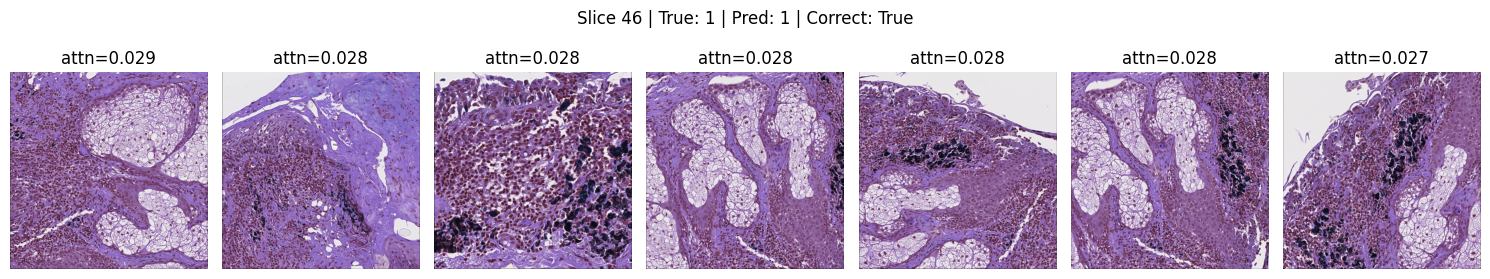


🧪 Slice #76: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_79_match_1_h&e_patch72.png: attention = 0.0675
  - case_79_match_1_h&e_patch117.png: attention = 0.0444
  - case_79_match_1_h&e_patch115.png: attention = 0.0440
  - case_79_match_1_h&e_patch142.png: attention = 0.0427
  - case_79_match_1_h&e_patch2.png: attention = 0.0416
  - case_79_match_1_h&e_patch62.png: attention = 0.0415
  - case_79_match_1_h&e_patch153.png: attention = 0.0379


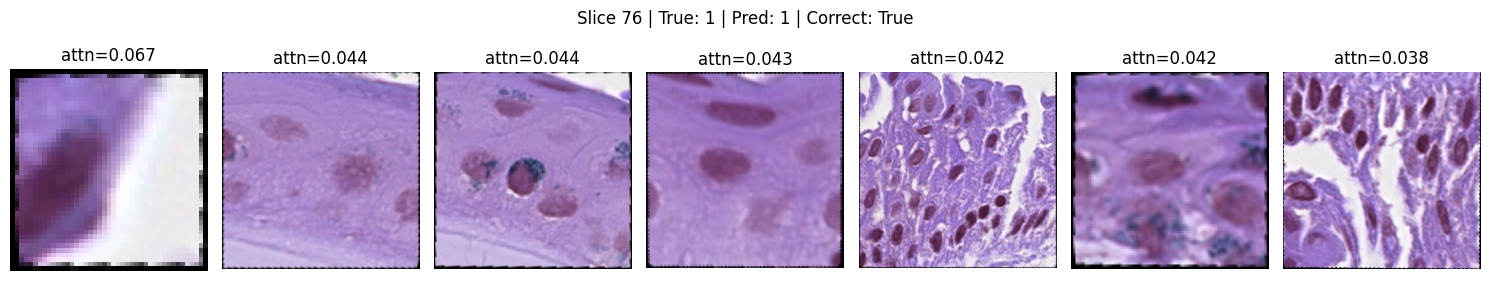


🧪 Slice #8: True label = 1, Predicted = 0, Correct = False
Top patches with highest attention:
  - case_104_unmatched_12_h&e_patch37.png: attention = 0.0343
  - case_104_unmatched_12_h&e_patch6.png: attention = 0.0327
  - case_104_unmatched_12_h&e_patch5.png: attention = 0.0324
  - case_104_unmatched_12_h&e_patch40.png: attention = 0.0297
  - case_104_unmatched_12_h&e_patch8.png: attention = 0.0291
  - case_104_unmatched_12_h&e_patch9.png: attention = 0.0291
  - case_104_unmatched_12_h&e_patch12.png: attention = 0.0286


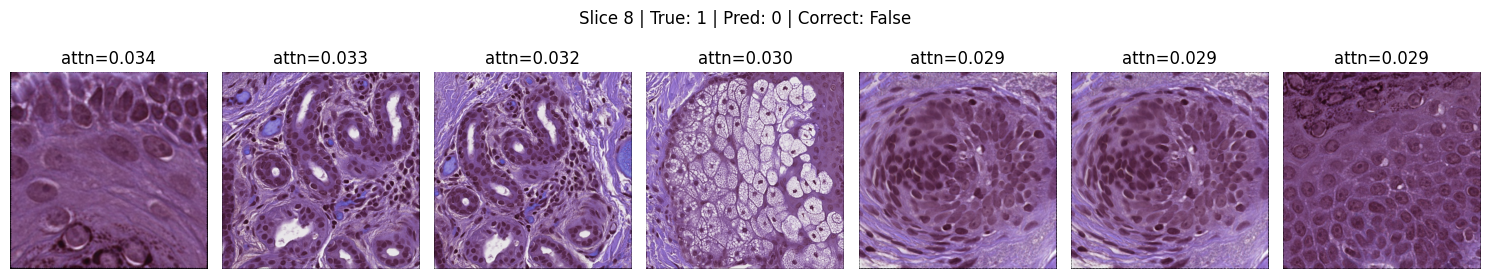


🧪 Slice #59: True label = 1, Predicted = 0, Correct = False
Top patches with highest attention:
  - case_38_match13_h&e_patch17.png: attention = 0.0395
  - case_38_match13_h&e_patch24.png: attention = 0.0383
  - case_38_match13_h&e_patch26.png: attention = 0.0351
  - case_38_match13_h&e_patch23.png: attention = 0.0348
  - case_38_match13_h&e_patch0.png: attention = 0.0346
  - case_38_match13_h&e_patch29.png: attention = 0.0345
  - case_38_match13_h&e_patch8.png: attention = 0.0345


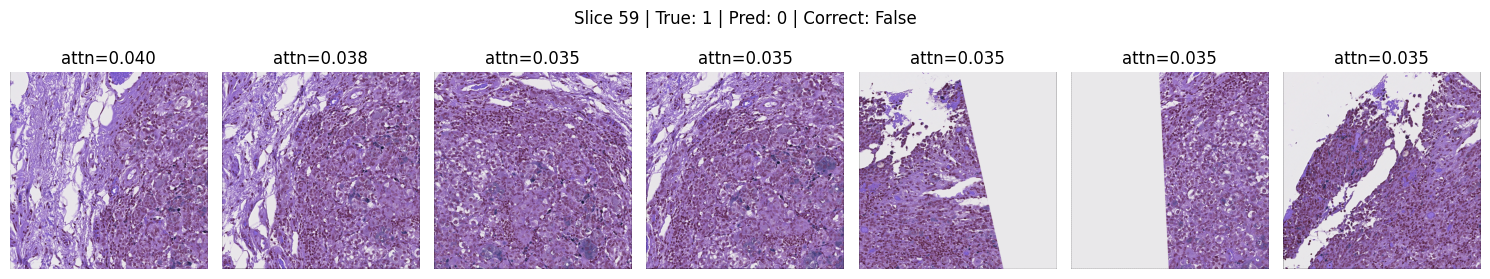


🧪 Slice #33: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_17_unmatched_3_h&e_patch15.png: attention = 0.0295
  - case_17_unmatched_3_h&e_patch17.png: attention = 0.0290
  - case_17_unmatched_3_h&e_patch54.png: attention = 0.0289
  - case_17_unmatched_3_h&e_patch53.png: attention = 0.0286
  - case_17_unmatched_3_h&e_patch16.png: attention = 0.0273
  - case_17_unmatched_3_h&e_patch36.png: attention = 0.0270
  - case_17_unmatched_3_h&e_patch37.png: attention = 0.0268


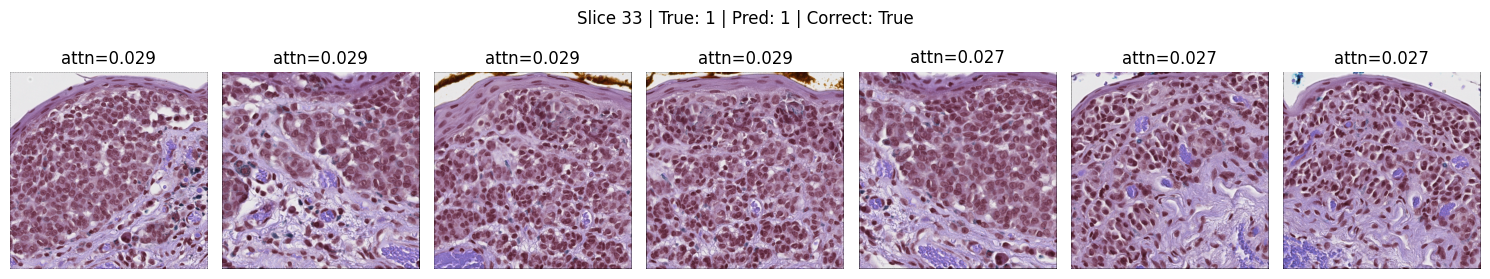


🧪 Slice #16: True label = 1, Predicted = 1, Correct = True
Top patches with highest attention:
  - case_104_match_12_h&e_patch8.png: attention = 0.0626
  - case_104_match_12_h&e_patch16.png: attention = 0.0620
  - case_104_match_12_h&e_patch0.png: attention = 0.0619
  - case_104_match_12_h&e_patch15.png: attention = 0.0619
  - case_104_match_12_h&e_patch14.png: attention = 0.0615
  - case_104_match_12_h&e_patch9.png: attention = 0.0607
  - case_104_match_12_h&e_patch13.png: attention = 0.0605


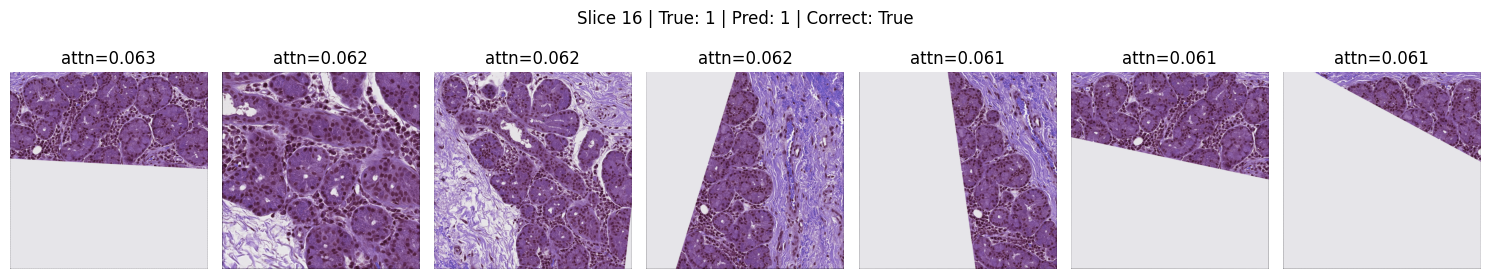


🧪 Slice #13: True label = 1, Predicted = 0, Correct = False
Top patches with highest attention:
  - case_104_unmatched_1_h&e_patch30.png: attention = 0.0163
  - case_104_unmatched_1_h&e_patch59.png: attention = 0.0143
  - case_104_unmatched_1_h&e_patch54.png: attention = 0.0142
  - case_104_unmatched_1_h&e_patch32.png: attention = 0.0142
  - case_104_unmatched_1_h&e_patch29.png: attention = 0.0138
  - case_104_unmatched_1_h&e_patch119.png: attention = 0.0138
  - case_104_unmatched_1_h&e_patch148.png: attention = 0.0138


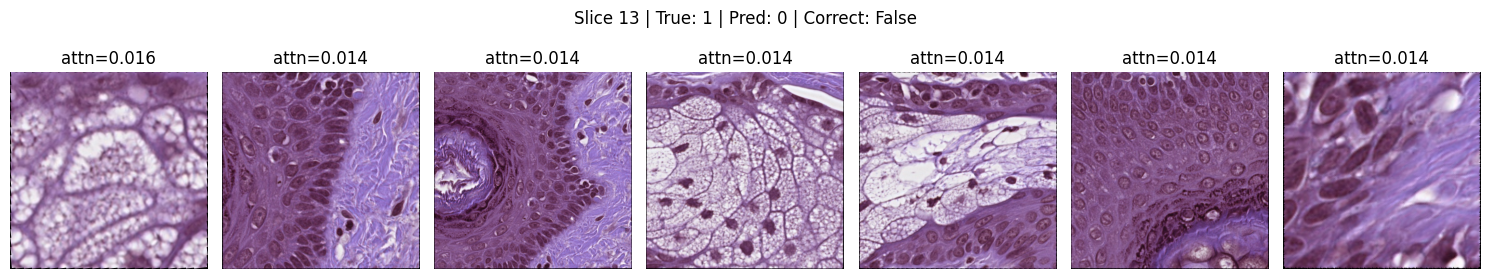

In [100]:
visualize_top_attended_patches(test_ds, all_attn_weights, all_patch_preds, all_patch_trues, num_cases=7, top_k=7)